<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/conv_lstm_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [2]:
import glob

folder_path = '/content/drive/MyDrive/opportunistic-utm/dataset'
folder_list = []
for folder in glob.iglob(folder_path + '/**/**/', recursive=False):
  folder_list.append(folder)

In [ ]:
folder_list

**Load Traffic Data**

In [ ]:
import numpy as np
from tqdm import tqdm
%config InlineBackend.figure_format = 'retina'

day_array = []
for folder in tqdm(folder_list):
  files = np.sort(glob.glob(folder + '/*.npy', recursive=False))
  hours_array = np.expand_dims(np.moveaxis(np.load(files[0]), 0, -1), 0)

  for i in range(1, 24):
    next_hour = np.expand_dims(np.moveaxis(np.load(files[i]), 0, -1), 0)
    hours_array = np.concatenate((hours_array, next_hour), axis=0)

  day_array.append(hours_array)

day_array = np.array(day_array)
day_array.shape

100%|██████████| 273/273 [24:31<00:00,  5.39s/it]


(273, 24, 100, 100, 20)

In [ ]:
# Save day array
np.save(f'{folder_path}/day_array_273.npy', day_array)

In [ ]:
# Load day array
import numpy as np
del day_array
day_array = np.load(f'{folder_path}/day_array_273.npy', mmap_mode='r')
day_array.shape

**Load Metadata**

In [ ]:
import numpy as np
from tqdm import tqdm
%config InlineBackend.figure_format = 'retina'

metadata_array = []
for folder in tqdm(folder_list):
  files = np.sort(glob.glob(folder + '/metadata/*.npy', recursive=False))
  hours_array = np.expand_dims(np.load(files[0]), 0)

  for i in range(1, 24):
    next_hour = np.expand_dims(np.load(files[i]), 0)
    hours_array = np.concatenate((hours_array, next_hour), axis=0)

  metadata_array.append(hours_array)

metadata_array = np.array(metadata_array)
metadata_array.shape

100%|██████████| 273/273 [18:28<00:00,  4.06s/it]


(273, 24, 25)

In [ ]:
# Save metadata array
np.save(f'{folder_path}/metadata_array_273.npy', metadata_array)

In [4]:
# Load metadata array
import numpy as np
metadata_array = np.load(f'{folder_path}/metadata_array_273.npy')
metadata_array.shape

(273, 24, 25)

**Flights Average**

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Flights average
flights_average = np.zeros([day_array.shape[2], day_array.shape[3], day_array.shape[-1]]) # (100, 100, 20)
for channel in tqdm(range(0, day_array.shape[-1])): # iterate channels
  for day in range(0, day_array.shape[0]): # iterate days
    flights_average[:, :, channel] += np.sum(day_array[day, :, :, :, channel], axis=0)

flights_average /= (day_array.shape[0] * day_array.shape[1]) # total_days x total_hours
flights_average = np.where(flights_average > 0.01, 1, 0)

In [ ]:
# Save average array
np.save(f'{folder_path}/flights_average_273.npy', flights_average)

In [5]:
# Load average array
import numpy as np
flights_average = np.load(f'{folder_path}/flights_average_273.npy')
flights_average.shape

(100, 100, 20)

In [ ]:
np.max(flights_average)

1

In [6]:
def flatten_array(input_array):
  len_array = input_array.shape[-1]
  levels_array = []
  for i in range(0, len_array):
    level = input_array[:, :, i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

In [8]:
# Max plot value
max_plot_value = .8

Level 0: 129
Level 1: 186
Level 2: 164
Level 3: 171
Level 4: 169
Level 5: 192
Level 6: 196
Level 7: 196
Level 8: 194
Level 9: 174
Level 10: 156
Level 11: 104
Level 12: 48
Level 13: 1
Level 14: 0
Level 15: 0
Level 16: 0
Level 17: 0
Level 18: 0
Level 19: 0
Maximum Value: 0.7


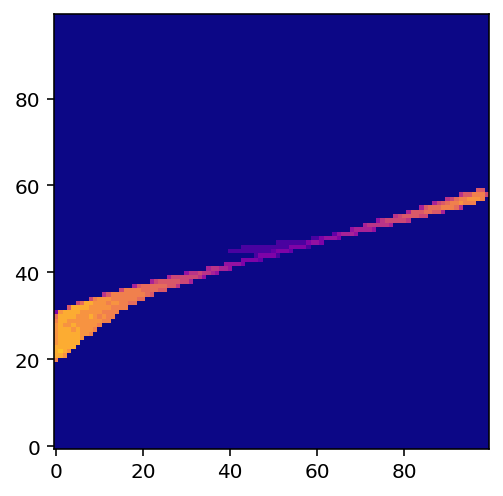

In [9]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

for i in range(0, flights_average.shape[-1]):
  print(f'Level {i}: {np.sum(flights_average[:,:,i])}')

flatten_average = flatten_array(flights_average)
plt.imshow(flatten_average, origin='lower', cmap = plt.get_cmap('plasma'))
print(f'Maximum Value: {np.max(flatten_average)}')
plt.clim(0, max_plot_value)
plt.show()

In [10]:
import numpy as np
np.set_printoptions(precision=1)

def SARMSE(original, predicted):
  layer_rmse = np.sqrt(np.sum(np.square(original-predicted)/100**2, axis=(0,1)))
  return np.sum(layer_rmse)/original.shape[-1] # divided by # of channels

# Tests
a = np.expand_dims(np.zeros([100,100]), -1)
b = np.expand_dims(np.ones([100,100]), -1)
c = np.stack([np.zeros([100,100]), np.zeros([100,100])], -1)
d = np.stack([np.ones([100,100]), np.ones([100,100])], -1)

# print(RMSE(a,b,0,1))
# print(RMSE(a,a,0,1))
# print(RMSE(b,b,0,1))

# print(RMSE(c,d))
# print(RMSE(c,c,0,2))
# print(RMSE(d,d,0,2))

In [14]:
import random

sum = 0
random_days = random.sample(range(59), 10)
print(f'Random Days: {random_days}')
for i in random_days:
  random_hours = random.sample(range(24), 10)
  print(f'Random Hours: {random_hours}')
  for j in random_hours:
    sum += SARMSE(day_array[i, j, :, :, :], flights_average)

print(f'SARMSE: {sum/100}')

Random Days: [10, 34, 2, 54, 30, 25, 7, 45, 4, 58]
Random Hours: [8, 23, 11, 22, 12, 10, 5, 14, 7, 2]
Random Hours: [6, 5, 4, 9, 7, 15, 14, 18, 0, 10]
Random Hours: [3, 0, 7, 21, 9, 2, 16, 11, 1, 8]
Random Hours: [8, 16, 9, 17, 4, 7, 22, 0, 5, 3]
Random Hours: [8, 11, 12, 2, 23, 4, 1, 15, 18, 20]
Random Hours: [21, 19, 17, 15, 16, 1, 11, 12, 9, 20]
Random Hours: [20, 5, 21, 22, 7, 4, 23, 19, 13, 6]
Random Hours: [22, 9, 17, 5, 19, 12, 7, 16, 4, 14]
Random Hours: [0, 18, 3, 16, 17, 2, 5, 21, 22, 9]
Random Hours: [9, 7, 21, 5, 16, 15, 22, 4, 6, 10]
SARMSE: 0.07678958704083937


**Flights Envelope**

(100, 100, 20)

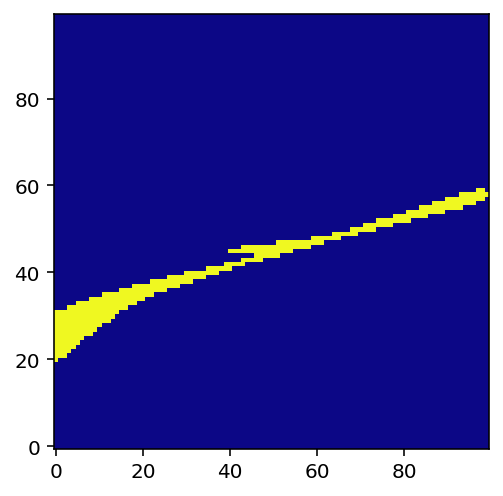

In [13]:
flights_envelope = np.where(flatten_average > 0, 1, 0)
stack = []
for i in range(0,20):
  stack.append(flights_envelope)

flights_envelope = np.array(stack)
flights_envelope = np.moveaxis(flights_envelope, 0, -1)
plt.imshow(flatten_array(flights_envelope), origin='lower', cmap='plasma')
flights_envelope.shape

**Masked Day Array**

In [ ]:
import numpy as np
from tqdm import tqdm

day_array = []
for folder in tqdm(folder_list):
  files = np.sort(glob.glob(folder + '/*.npy', recursive=False))
  hours_array = np.expand_dims(np.moveaxis(np.load(files[0]), 0, -1)*flights_envelope, 0)

  for i in range(1, 24):
    next_hour = np.expand_dims(np.moveaxis(np.load(files[i]), 0, -1)*flights_envelope, 0)
    hours_array = np.concatenate((hours_array, next_hour), axis=0)

  day_array.append(hours_array)

day_array = np.array(day_array)
day_array.shape

100%|██████████| 273/273 [01:54<00:00,  2.38it/s]


(273, 24, 100, 100, 20)

In [ ]:
# Save masked day array
np.save(f'{folder_path}/day_array_273_masked.npy', day_array)

In [ ]:
del day_array

In [9]:
# Load day array
import numpy as np
day_array = np.load(f'{folder_path}day_array_273_masked.npy', mmap_mode='r')
day_array.shape

(273, 24, 100, 100, 20)

**Visualization**


In [15]:
# 2D Visualization
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
%config InlineBackend.figure_format = 'retina'

def level_transform(input_array, hour):
  levels_array = []
  len_array = input_array[hour, ...].shape[-1]
  for i in range(0, len_array):
    level = input_array[hour, ..., i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)


def browse_images(day_array):
    def view_hour(day, hour):
        plt.imshow(level_transform(day_array[day-1], hour), origin='lower', cmap = plt.get_cmap('plasma'))
        plt.clim(0, max_plot_value)
        print(np.max(level_transform(day_array[day-1], hour)))
        plt.show()
    interact(view_hour, day=widgets.IntSlider(min=1, max=day_array.shape[0], step=1, value=0), hour=widgets.IntSlider(min=0, max=23, step=1, value=0))

browse_images(day_array)

interactive(children=(IntSlider(value=1, description='day', max=273, min=1), IntSlider(value=0, description='h…

In [16]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

def browse_images(day_array):
    def view_hour(day):
      fig, ax = plt.subplots(6, 4, figsize=(15, 15))
      for idx, ax in enumerate(ax.flat):
        plot = ax.imshow(level_transform(day_array[day-1], idx), origin='lower', cmap = plt.get_cmap('plasma'))
        # plot.set_clim(vmin=0, vmax=max_plot_value)
        ax.set_title(f'Day {day} / Hour {idx}')
        ax.axis("off")
        
    
    interact(view_hour, day=widgets.IntSlider(min=1, max=day_array.shape[0], step=1, value=0))

browse_images(day_array)

interactive(children=(IntSlider(value=1, description='day', max=273, min=1), Output()), _dom_classes=('widget-…

In [ ]:
# 3D Visualization
import plotly.graph_objects as go
import pandas as pd
import random

def ms(x, y, z, radius, resolution=5):
  u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
  X = radius * np.cos(u)*np.sin(v) + x
  Y = radius * np.sin(u)*np.sin(v) + y
  Z = radius * np.cos(v) + z
  return (X, Y, Z)

# Append spheres
day = 14
hour = 8

data = []
layers_df = pd.DataFrame(columns=['layer', 'x', 'y'])
cmap = plt.cm.get_cmap('plasma', 16)
for layer in range(0, day_array[day-1,...].shape[-1]): # looping layers
  layer_array = day_array[day-1, hour, ..., layer]
  
  for i in range(0, layer_array.shape[0]):
    for j in range(0, layer_array.shape[1]):
      if layer_array[i,j] == 1:
        layers_df.loc[len(layers_df)] = [layer, j, i]

data.append(go.Scatter3d(
          x= layers_df['x'],
          y= layers_df['y'],
          z= layers_df['layer'],
          name='layers',
          mode='markers',
          marker=dict(color=layers_df['layer'],colorscale='Plasma')))

layout = go.Layout(scene=dict(
  xaxis = dict(range=[0, 100]),
  yaxis = dict(range=[0, 100]),
  zaxis = dict(range=[-1, 20])))
        
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=-1, z=2)
)

fig = go.Figure(data=data, layout=layout)
fig.update_layout(scene_camera=camera)
fig.show()

# ConvLSTM

In [17]:
def create_shifted_frames(data):
  shift = 1
  x = data[:, 0 : data.shape[1] - shift, :, :]
  y = data[:, shift : data.shape[1], :, :]
  return x, y

def create_shifted_metadata(data):
  shift = 1
  x = data[:, 0 : data.shape[1] - shift, :]
  y = data[:, shift : data.shape[1], :]
  return x, y

In [18]:
x_train, y_train = create_shifted_frames(day_array[0:180])
x_val, y_val = create_shifted_frames(day_array[200:230])
x_test = day_array[260:270]
print(f'x_train shape: {x_train.shape} / y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape} / y_val shape: {y_val.shape}')

x_train shape: (180, 23, 100, 100, 20) / y_train shape: (180, 23, 100, 100, 20)
x_val shape: (30, 23, 100, 100, 20) / y_val shape: (30, 23, 100, 100, 20)


In [19]:
x_mtrain, y_mtrain = create_shifted_metadata(metadata_array[0:180])
x_mval, y_mval = create_shifted_metadata(metadata_array[200:230])
x_mtest = metadata_array[260:270]
print(f'x_mtrain shape: {x_mtrain.shape} / y_mtrain shape: {y_mtrain.shape}')
print(f'x_mval shape: {x_mval.shape} / y_mval shape: {y_mval.shape}')

x_mtrain shape: (180, 23, 25) / y_mtrain shape: (180, 23, 25)
x_mval shape: (30, 23, 25) / y_mval shape: (30, 23, 25)


In [43]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, GRU, Dropout, TimeDistributed, MaxPooling3D

import io
import imageio

# Custom Loss Function

In [49]:
# def SARMSE(original, predicted):
#   layer_rmse = np.sqrt(np.sum(np.square(original-predicted)/100**2, axis=(0,1)))
#   return np.sum(layer_rmse)/original.shape[-1] # divided by # of channels

def custom_sarmse(y_true, y_pred):
	print(f'True shape: {y_true.shape}')
	print(f'Pred shape: {y_pred.shape}')
	accum = 0
	for i in range(0, y_true.shape[0]):
		for j in range(0, y_true.shape[1]):
			a = tf.square(y_true[i,j] - y_pred[i,j] + 1e-10)
			b = tf.reduce_sum(a, [0,1])/10000
			c = tf.sqrt(b)
			d = tf.reduce_sum(c)/20
			accum += d		
	return accum

In [51]:
from keras import backend as K

def custom_sarmse(y_true, y_pred):
  print(f'True shape: {y_true.shape}')
  print(f'Pred shape: {y_pred.shape}')
  a = K.square(y_true-y_pred)
  b = K.sum(a, [2,3], keepdims=True)
  c = K.sqrt(b)
  d = K.sum(c)/(100*20)
  return d

In [52]:
custom_sarmse(day_array[0:2], day_array[1:3])

True shape: (2, 24, 100, 100, 20)
Pred shape: (2, 24, 100, 100, 20)


<tf.Tensor: shape=(), dtype=float64, numpy=1.1654977465300276>

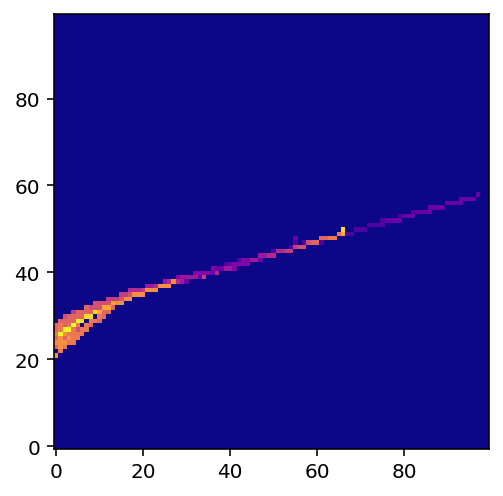

In [ ]:
plt.imshow(flatten_array(day_array[13][8]*flights_envelope), origin='lower', cmap = plt.get_cmap('plasma'))

# Model 1

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

a = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

b = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

c = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

x = tf.keras.layers.Concatenate()([a, b, c])
x = TimeDistributed(layers.BatchNormalization())(x)
x = TimeDistributed(layers.Dropout(0.2))(x)

x = layers.ConvLSTM2D(
    filters=20,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
    data_format='channels_last'
)(x)

model = keras.models.Model(inputs = [inp], outputs = x)
model.compile(
  loss=custom_sarmse, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, None, 100, 1  60032       ['input_1[0][0]']                
                                00, 32)                                                           
                                                                                                  
 conv_lstm2d_1 (ConvLSTM2D)     (None, None, 100, 1  57664       ['input_1[0][0]']                
                                00, 16)                                                       

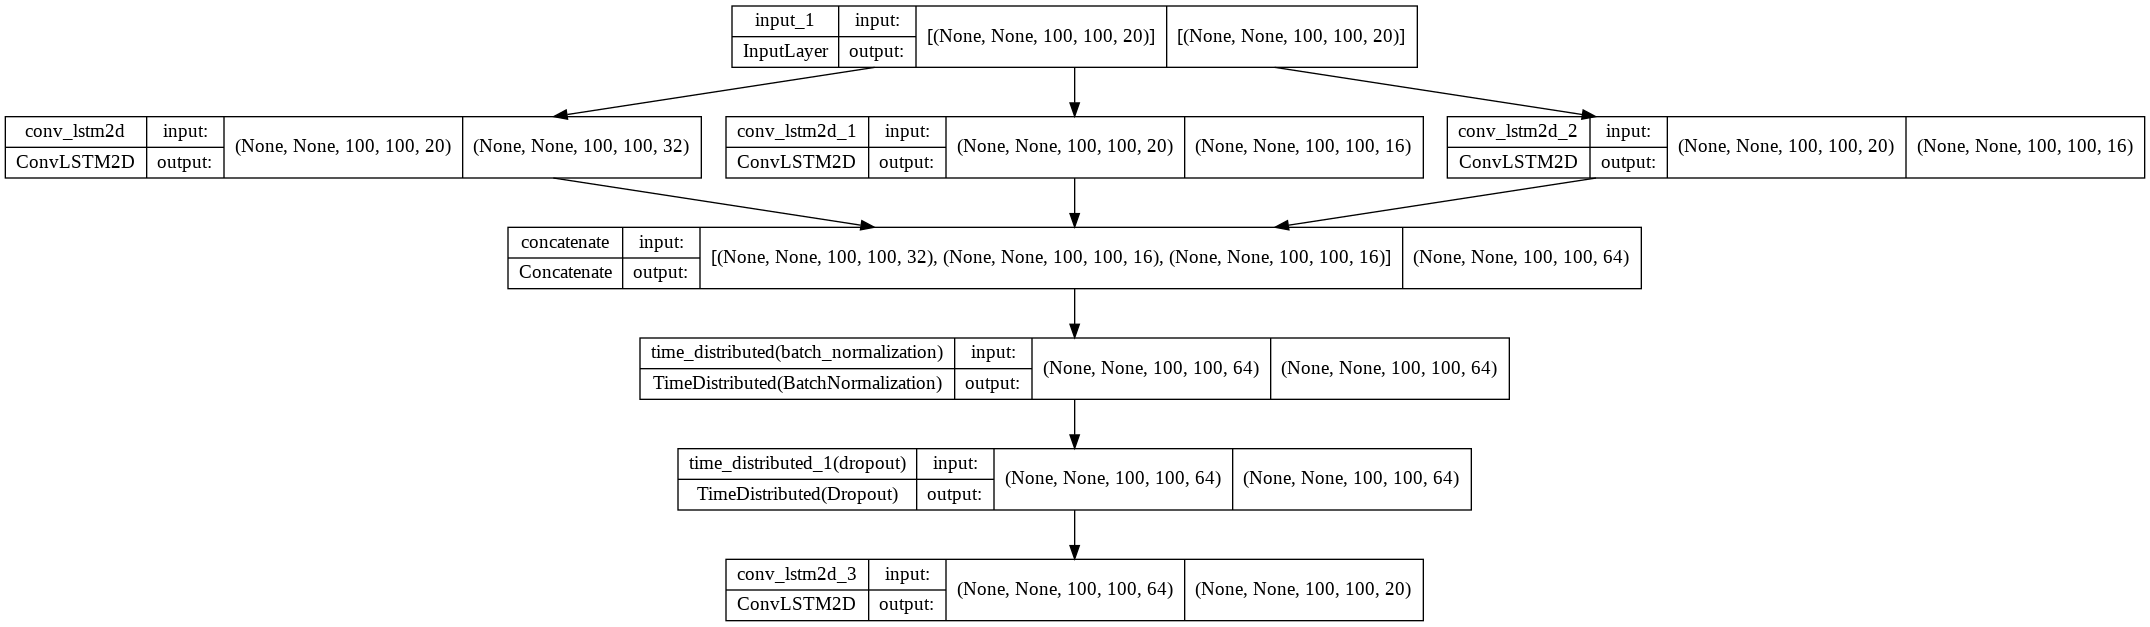

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Model 2

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
layer1 = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

layer2 = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

layer3 = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

x = tf.keras.layers.Concatenate()([layer1, layer2, layer3])
# x = TimeDistributed(layers.BatchNormalization())(x)
# x = TimeDistributed(layers.Dropout(0.2))(x)

x = layers.Conv3D(
    filters=20, kernel_size=(3, 3, 3), activation="relu", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 conv_lstm2d_6 (ConvLSTM2D)     (None, None, 100, 1  166528      ['input_3[0][0]']                
                                00, 32)                                                           
                                                                                                  
 conv_lstm2d_7 (ConvLSTM2D)     (None, None, 100, 1  20800       ['input_3[0][0]']                
                                00, 16)                                                     

# Model 3

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(7, 7),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(inp)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(
    filters=20, kernel_size=(10, 10, 10), activation="sigmoid", padding="same", data_format='channels_last'
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None, 100, 100,   0         
                             20)]                                
                                                                 
 conv_lstm2d_40 (ConvLSTM2D)  (None, None, 100, 100, 3  326272   
                             2)                                  
                                                                 
 batch_normalization_34 (Bat  (None, None, 100, 100, 3  128      
 chNormalization)            2)                                  
                                                                 
 conv_lstm2d_41 (ConvLSTM2D)  (None, None, 100, 100, 1  76864    
                             6)                                  
                                                                 
 batch_normalization_35 (Bat  (None, None, 100, 100, 1  64

# Model 4


In [30]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))
minp = layers.Input(shape=(None, *x_mtrain.shape[2:]))

def repeat_tabular(x_tab):
  h = x_tab[:, :, :, None, None]
  h = tf.tile(h, [1, 1, 4, 100, 1]) 
  return h

a = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

b = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

c = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

y = tf.keras.layers.LSTM(64, return_sequences=True)(minp)
y = layers.Lambda(repeat_tabular)(minp)

x = tf.keras.layers.Concatenate()([a, b, c, y])
x = TimeDistributed(layers.BatchNormalization())(x)
# x = TimeDistributed(layers.Dropout(0.2))(x)

x = layers.ConvLSTM2D(
    filters=20,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
    data_format='channels_last'
)(x)

model = keras.models.Model(inputs = [inp, minp], outputs = x)
model.compile(
    loss=custom_sarmse, optimizer=keras.optimizers.Adam(learning_rate = 0.001), # metrics=['accuracy'],
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 input_6 (InputLayer)           [(None, None, 25)]   0           []                               
                                                                                                  
 conv_lstm2d_8 (ConvLSTM2D)     (None, None, 100, 1  60032       ['input_5[0][0]']                
                                00, 32)                                                           
                                                                                            

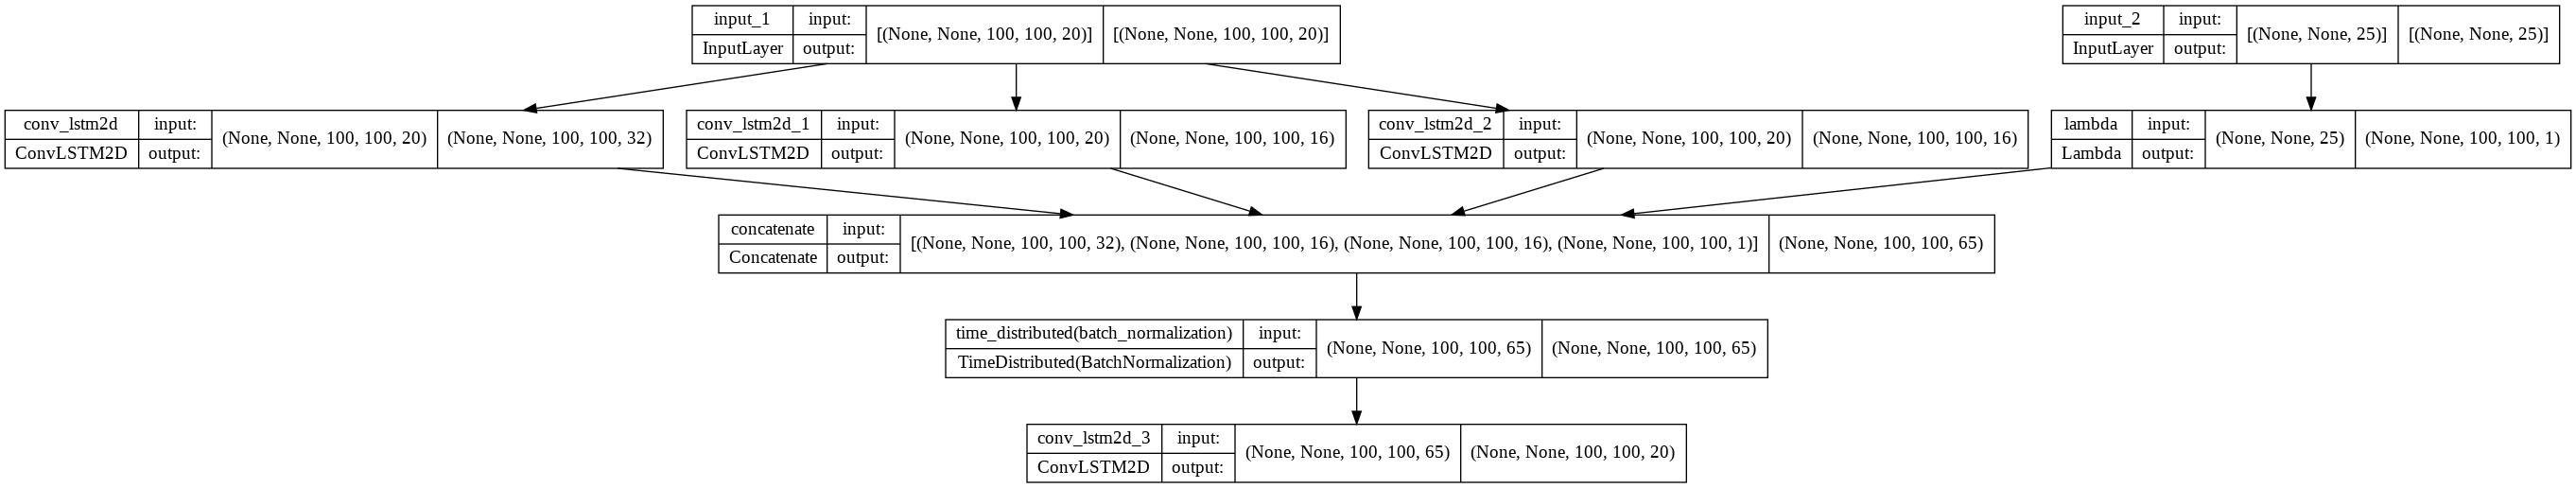

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training Single Input

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 1

# Fit the model to the training data.
history = model.fit(
    x= [x_train],
    y= [y_train],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([x_val], y_val),
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/20
True shape: (1, 23, 100, 100, 20)
Pred shape: (1, 23, 100, 100, 20)
True shape: (1, 23, 100, 100, 20)
Pred shape: (1, 23, 100, 100, 20)
180/180 [==============================] - ETA: 0s - loss: 1.6758True shape: (1, 23, 100, 100, 20)
Pred shape: (1, 23, 100, 100, 20)
180/180 [==============================] - 86s 369ms/step - loss: 1.6758 - val_loss: 0.5208 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 59s 329ms/step - loss: 0.4256 - val_loss: 0.5052 - lr: 0.0010
Epoch 3/20
180/180 [==============================] - 59s 330ms/step - loss: 0.4183 - val_loss: 0.4515 - lr: 0.0010
Epoch 4/20
180/180 [==============================] - 59s 330ms/step - loss: 0.4132 - val_loss: 0.4239 - lr: 0.0010
Epoch 5/20
180/180 [==============================] - 59s 330ms/step - loss: 0.4096 - val_loss: 0.4156 - lr: 0.0010
Epoch 6/20
180/180 [==============================] - 59s 330ms/step - loss: 0.4079 - val_loss: 0.4161 - lr: 0.0010
Epoch 7/20
180/180 [===============

# Training Dual Input

In [31]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 1

# Fit the model to the training data.
history = model.fit(
    x= [x_train, x_mtrain],
    y= [y_train, y_mtrain],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([x_val, x_mval], y_val),
    callbacks=[early_stopping, reduce_lr],
)

InternalError: ignored

# Metrics

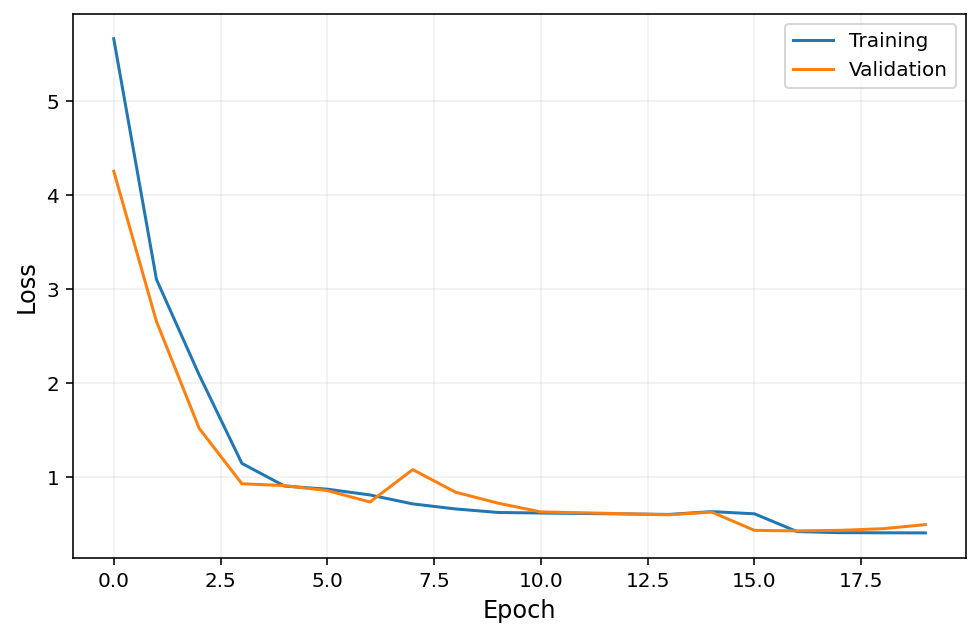

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('', fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.axis('on')
plt.grid('on', alpha=.2)
plt.show()

# Evaluation Single Input

SARMSE ConvLSTM Prediction: 0.033341520202572764
SARMSE Average Prediction: 0.07550745774798748
Original Max: 0.5
Predicted Max: 0.45


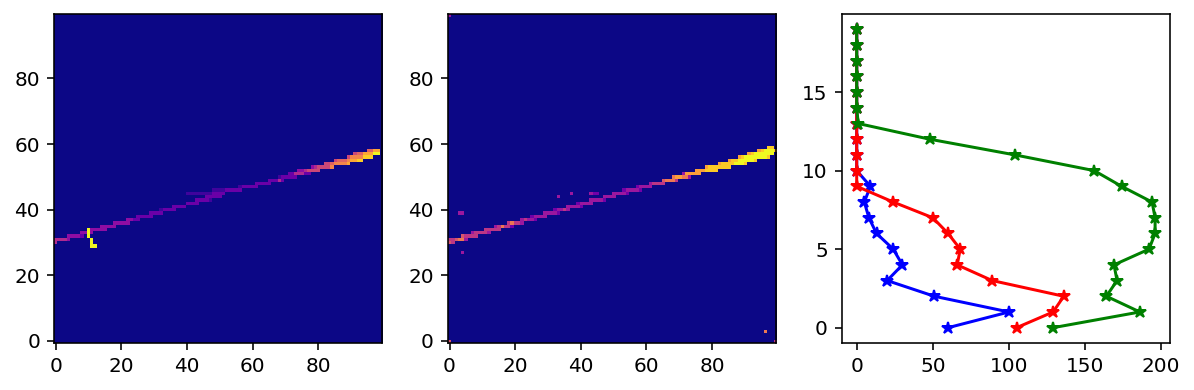

In [ ]:
# Select a random example from the validation dataset.
day = 0
example = x_test[day]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]
new_prediction = model.predict([np.expand_dims(frames, axis=0)])
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
predicted_frame = np.where(predicted_frame > 0, 1, 0)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(131)
ax1.imshow(flatten_array(original_frames[0]), origin='lower', cmap = plt.get_cmap('plasma')) #, vmin=0, vmax=max_plot_value)

ax2 = fig.add_subplot(132)
ax2.imshow(flatten_array(predicted_frame[0]), origin='lower', cmap = plt.get_cmap('plasma')) #, vmin=0, vmax=max_plot_value)

original_level_count = []
for i in range(0, 20):
  original_level_count.append(np.count_nonzero(original_frames[0][:,:,i]))

predicted_level_count = []
for i in range(0, 20):
  predicted_level_count.append(np.count_nonzero(predicted_frame[0][:,:,i]))

average_level_count = []
for i in range(0, 20):
  average_level_count.append(np.count_nonzero(flights_average[:,:,i]))

ax3 = fig.add_subplot(133)
ax3.plot(original_level_count, np.linspace(0, 19, 20), 'b*-')
ax3.plot(predicted_level_count, np.linspace(0, 19, 20), 'r*-')
ax3.plot(average_level_count, np.linspace(0, 19, 20), 'g*-')

asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp)

# print(f'SARMSE Null Prediction: {SARMSE(original_frames[0], np.zeros((100,100,20)))}')
print(f'SARMSE ConvLSTM Prediction: {SARMSE(original_frames[0], predicted_frame[0])}')
print(f'SARMSE Average Prediction: {SARMSE(original_frames[0], flights_average)}')
print(f'Original Max: {np.max(flatten_array(original_frames[0]))}')
print(f'Predicted Max: {np.max(flatten_array(predicted_frame[0]))}')


In [ ]:
# Select a random example from the validation dataset.
hour = 4
sum = 0
for day in range(0, x_test.shape[0]):
  example = x_test[day]

  # Pick the first/last ten frames from the example.
  frames = example[:10, ...]
  original_frames = example[10:, ...]
  new_prediction = model.predict([np.expand_dims(frames, axis=0)])
  new_prediction = np.squeeze(new_prediction, axis=0)
  predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
  predicted_frame = np.where(predicted_frame > 0, 1, 0)

  sarmse = SARMSE(original_frames[hour], predicted_frame[0])
  sum += sarmse
  print(f'SARMSE ConvLSTM Prediction: {sarmse}')

average = sum/x_test.shape[0]
print(f'SARMSE Average: {average}')

SARMSE ConvLSTM Prediction: 0.033341520202572764
SARMSE ConvLSTM Prediction: 0.04919727372772159
SARMSE ConvLSTM Prediction: 0.03761541460199452
SARMSE ConvLSTM Prediction: 0.04214349785563579
SARMSE ConvLSTM Prediction: 0.04437254427666176
SARMSE ConvLSTM Prediction: 0.050638931820538545
SARMSE ConvLSTM Prediction: 0.052666050694240595
SARMSE ConvLSTM Prediction: 0.04345156549073838
SARMSE ConvLSTM Prediction: 0.0503367625327633
SARMSE ConvLSTM Prediction: 0.04631665030849566
SARMSE Average: 0.04500802115113629


# Evaluation Dual Input


SARMSE ConvLSTM Prediction: 0.050221753716806664
SARMSE Average Prediction: 0.07550745774798748
Original Max: 0.5
Predicted Max: 0.8


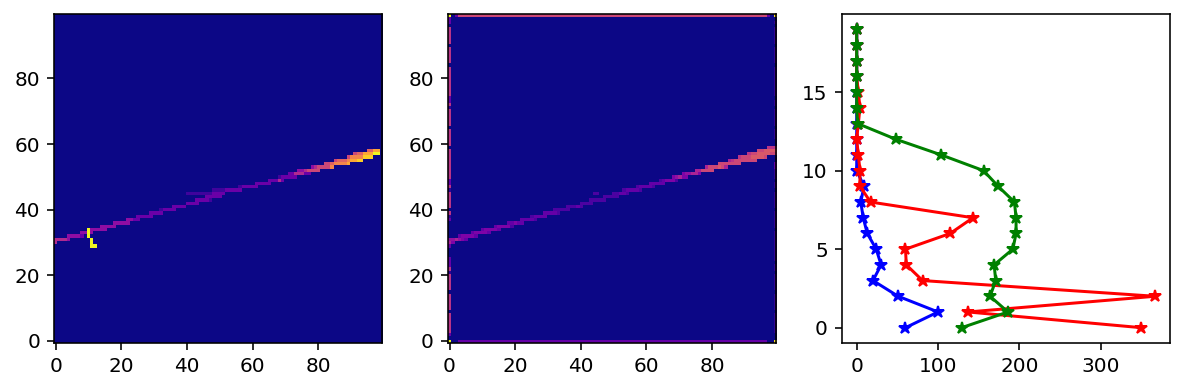

In [29]:
# Select a random example from the validation dataset.
day = 0
hour = 0
example = x_test[day]
mexample = x_mtest[day]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
mframes = mexample[:10, ...]
original_frames = example[10:, ...]

new_prediction = model.predict([np.expand_dims(frames, axis=0), np.expand_dims(mframes, axis=0)])
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
predicted_frame = np.where(predicted_frame > 0, 1, 0)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(131)
ax1.imshow(flatten_array(original_frames[hour]), origin='lower', cmap = plt.get_cmap('plasma')) #, vmin=0, vmax=max_plot_value)

ax2 = fig.add_subplot(132)
ax2.imshow(flatten_array(predicted_frame[0]), origin='lower', cmap = plt.get_cmap('plasma')) #, vmin=0, vmax=max_plot_value)

original_level_count = []
for i in range(0, 20):
  original_level_count.append(np.count_nonzero(original_frames[hour][:,:,i]))

predicted_level_count = []
for i in range(0, 20):
  predicted_level_count.append(np.count_nonzero(predicted_frame[0][:,:,i]))

average_level_count = []
for i in range(0, 20):
  average_level_count.append(np.count_nonzero(flights_average[:,:,i]))

ax3 = fig.add_subplot(133)
ax3.plot(original_level_count, np.linspace(0, 19, 20), 'b*-')
ax3.plot(predicted_level_count, np.linspace(0, 19, 20), 'r*-')
ax3.plot(average_level_count, np.linspace(0, 19, 20), 'g*-')

asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp)

# print(f'SARMSE Null Prediction: {SARMSE(original_frames[0], np.zeros((100,100,20)))}')
print(f'SARMSE ConvLSTM Prediction: {SARMSE(original_frames[hour], predicted_frame[0])}')
print(f'SARMSE Average Prediction: {SARMSE(original_frames[hour], flights_average)}')
print(f'Original Max: {np.max(flatten_array(original_frames[hour]))}')
print(f'Predicted Max: {np.max(flatten_array(predicted_frame[0]))}')


In [ ]:
predicted_frame.shape

(1, 100, 100, 20)

In [ ]:
# Check the whole test dataset
hour = 4
sum = 0
for day in range(0, x_test.shape[0]):
  example = x_test[day]
  mexample = x_mtest[day]

  # Pick the first/last ten frames from the example.
  frames = example[:10, ...]
  mframes = mexample[:10, ...]
  original_frames = example[10:, ...]
  new_prediction = model.predict([np.expand_dims(frames, axis=0), np.expand_dims(mframes, axis=0)])
  new_prediction = np.squeeze(new_prediction, axis=0)
  predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
  predicted_frame = np.where(predicted_frame > 0, 1, 0)

  sarmse = SARMSE(original_frames[hour], predicted_frame[0])
  sum += sarmse
  print(f'SARMSE ConvLSTM Prediction: {sarmse}')

average = sum/x_test.shape[0]
print(f'SARMSE Average: {average}')

SARMSE ConvLSTM Prediction: 0.030504763744206288
SARMSE ConvLSTM Prediction: 0.04883188806697848
SARMSE ConvLSTM Prediction: 0.04086413614263687
SARMSE ConvLSTM Prediction: 0.03124753161744757
SARMSE ConvLSTM Prediction: 0.05171068068860416
SARMSE ConvLSTM Prediction: 0.0401035818285608
SARMSE ConvLSTM Prediction: 0.04918099866164996
SARMSE ConvLSTM Prediction: 0.0468417376796145
SARMSE ConvLSTM Prediction: 0.04163312652459
SARMSE ConvLSTM Prediction: 0.044725043125457456
SARMSE Average: 0.04256434880797461


(10, 24, 100, 100, 20)

# Multiple Prediction

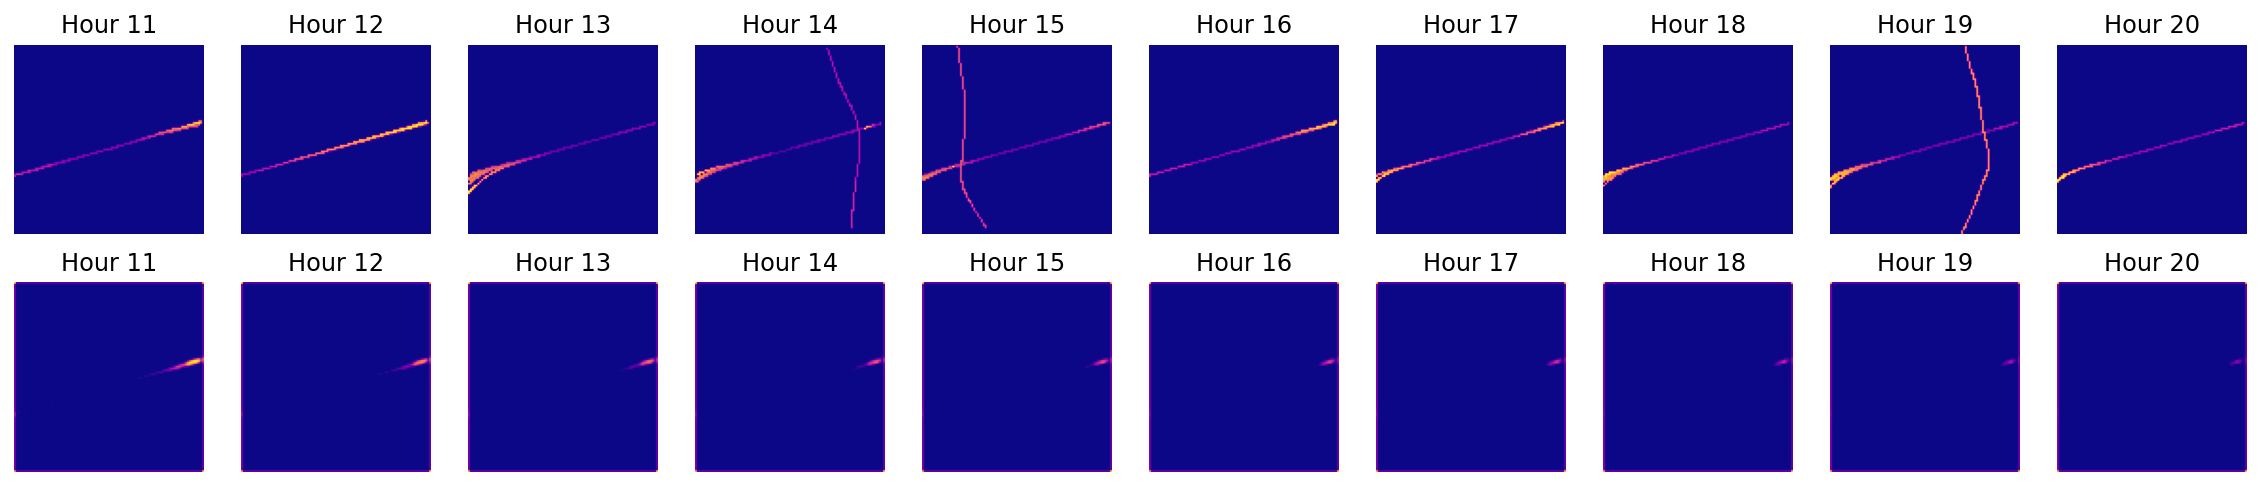

In [ ]:
# Select a random example from the validation dataset.
example = x_test[1]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict([np.expand_dims(frames, axis=0)])
    # new_prediction[new_prediction > .5] = 1
    # new_prediction[new_prediction < .5] = 0

    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    # predicted_frame = np.where(predicted_frame > 0.01, 1, 0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
  
    ax.imshow(level_transform(original_frames, idx), origin='lower', cmap = plt.get_cmap('plasma'))
    # ax.imshow(np.amax(original_frames[idx], axis=2), origin='lower')
    ax.set_title(f"Hour {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(level_transform(new_frames, idx), origin='lower', cmap = plt.get_cmap('plasma'))
    # ax.imshow(np.amax(new_frames[idx], axis=2), origin='lower')
    ax.set_title(f"Hour {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

SARMSE_list = []
for i in range(0, new_frames.shape[0]):
  SARMSE_list.append(SARMSE(original_frames[i], new_frames[i]))

ax.plot(SARMSE_list, 'b*-')
ax.set_xlabel('Day')
ax.set_ylabel('SARMSE (%)')